# Shockwave

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [28]:
# Parameters
L = 1.0         # Length of the domain
T = 1.0         # Total simulation time
Nx = 200        # Number of spatial points
Nt = 800        # Number of time steps
dx = L / (Nx - 1)
dt = T / Nt

In [29]:
# Initial conditions
x = np.linspace(0, L, Nx)
u = 0.8*np.ones(Nx) #np.exp(-(x - 0.5*L)**2 / 0.1)             # Velocity
rho = np.exp(-(x-0.1*L)**2 /0.001)
energy = np.exp(-(x-0.5*L)**2 /0.08)

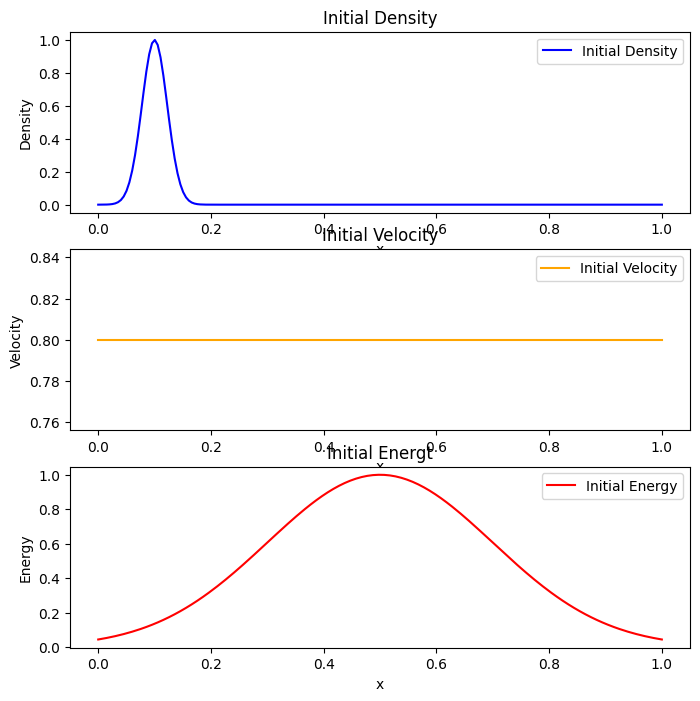

In [30]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
axs[0].plot(x, rho, label='Initial Density', color='blue')
axs[0].set_title('Initial Density')
axs[0].set_xlabel('x')
axs[0].set_ylabel('Density')
axs[0].legend()

axs[1].plot(x, u, label='Initial Velocity', color='orange')
axs[1].set_title('Initial Velocity')
axs[1].set_xlabel('x')
axs[1].set_ylabel('Velocity')
axs[1].legend()

axs[2].plot(x, energy, label='Initial Energy', color='red')
axs[2].set_title('Initial Energt')
axs[2].set_xlabel('x')
axs[2].set_ylabel('Energy')
axs[2].legend()

In [31]:
sol_rho = np.zeros((rho.shape[0], Nt+1))
sol_mom = np.zeros((rho.shape[0], Nt+1))
sol_ene = np.zeros((rho.shape[0], Nt+1))

P = 0

sol_rho[:, 0] = rho
sol_mom[:, 0] = rho * u
sol_ene[:, 0] = energy

In [32]:
diff_rho = np.zeros(Nx)
diff_mom = np.zeros(Nx)
diff_ene = np.zeros(Nx)
v = np.zeros(Nx)
v_prov = np.zeros(Nx-1)

for i in range(1, Nt+1):
    v[sol_rho[:,i-1]!=0] = sol_mom[:, i-1][sol_rho[:,i-1]!=0]/sol_rho[:,i-1][sol_rho[:,i-1]!=0]
    
    f_rho = sol_mom[:,i-1]
    f_mom = P + sol_rho[:,i-1]*v**2
    f_ene = v * (sol_ene[:,i-1] + P)
    
    u_prov = 0.5*(sol_mom[1:,i-1] + sol_mom[:-1,i-1]) - 0.5*dt*(f_mom[1:] - f_mom[:-1])/dx
    r_prov = 0.5*(sol_rho[1:,i-1] + sol_rho[:-1,i-1]) - 0.5*dt*(f_rho[1:] - f_rho[:-1])/dx
    e_prov = 0.5*(sol_ene[1:,i-1] + sol_ene[:-1,i-1]) - 0.5*dt*(f_ene[1:] - f_ene[:-1])/dx

    v_prov[r_prov!=0] = u_prov[r_prov!=0]/r_prov[r_prov!=0]
    
    f_rho_prov = u_prov
    f_mom_prov = P + r_prov*v_prov**2
    f_ene_prov = v_prov*(e_prov + P)

    diff_rho[1:-1] = f_rho_prov[1:] - f_rho_prov[:-1]
    diff_mom[1:-1] = f_mom_prov[1:] - f_mom_prov[:-1]
    diff_ene[1:-1] = f_ene_prov[1:] - f_ene_prov[:-1]

    sol_mom[:,i] = sol_mom[:,i-1] - dt*(diff_mom)/dx
    sol_rho[:,i] = sol_rho[:,i-1] - dt*(diff_rho)/dx
    sol_ene[:,i] = sol_ene[:,i-1] - dt*(diff_ene)/dx

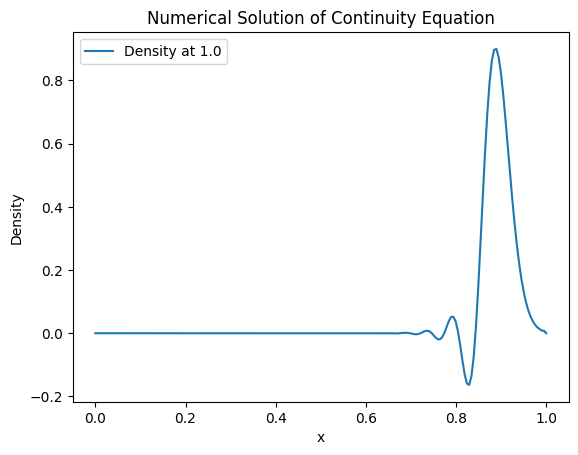

In [48]:
idx = 800
plt.plot(x, sol_rho[:,idx], label=f'Density at {T * idx/Nt}')
plt.title('Numerical Solution of Continuity Equation')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()